In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#dados das eleições dos anos de 2006 e 2010
data = pd.read_csv("../data/train.csv")

#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome'])

#selecionando atributos numéricos
numeric_feats = data.dtypes[data.dtypes != "object"].index

#normalizando variáveis numéricas
data[numeric_feats] = np.log1p(data[numeric_feats])

#dummy das variáveis categoricas
X_train = data.drop(columns=['situacao'])
X_train = pd.get_dummies(X_train)
#dumy da variável alvo, eleito = 1 e nao_eleito = 0
Y_train = data.situacao
Y_train = Y_train.replace(['nao_eleito', 'eleito'], [0, 1])

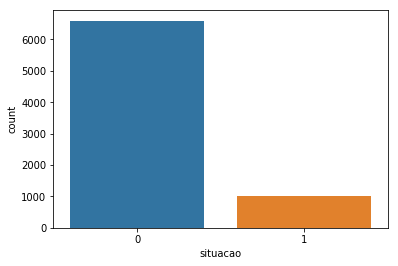

In [3]:
#plotando distribuição da variável resposta
sns.countplot(Y_train)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem do modelo. Isso pode ser tratrado por meio de técnicas de `Under-sampling`, neste caso vou utilizar NearMiss version 1 que pioriza a fronteira de decisão entre as classes.

/home/diogo/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


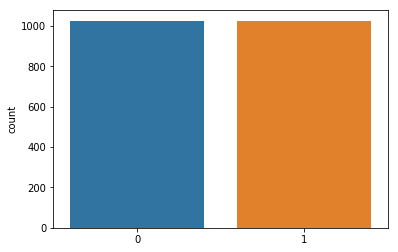

In [4]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=1)
X_train, Y_train = nm.fit_resample(X_train, Y_train)
sns.countplot(Y_train)

Função para calcular o AUC-Precision&Recall na validação cruzada

In [9]:
from sklearn.model_selection import cross_val_score
def f1_cv(model):
    f1 = cross_val_score(model, X_train, Y_train, scoring='f1_macro', cv=5)
    return(f1)

### Regressão Logistíca

NameError: name 'plt' is not defined

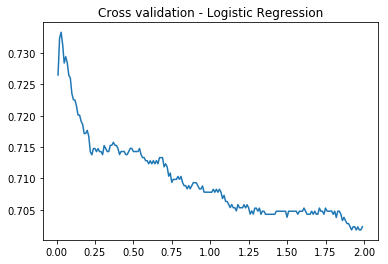

In [10]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.01,2,0.01).tolist()

cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1)).mean()
            for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

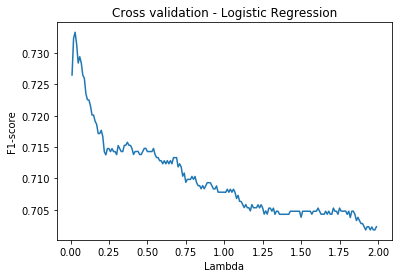

O melhor alpha é 0.03, com F1 = 0.733321661993


In [11]:
import matplotlib.pyplot as plt
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))